In [2]:
# Import numpy and matplotlib, and use jupyter magic to
# get plots directly in notebook
import numpy as np
import sys
import random
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
# Get nicer looking plots than default
plt.style.use('bmh')

## Example of limited precision

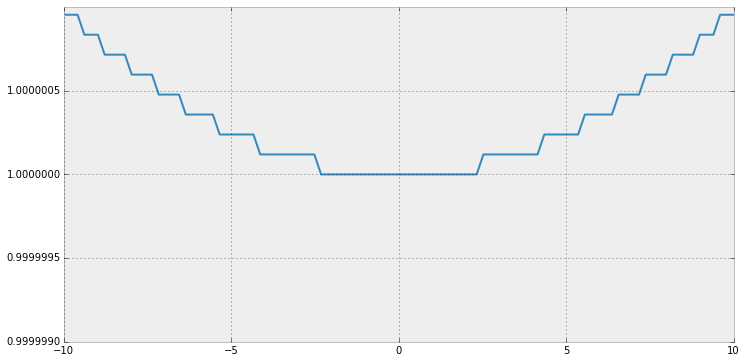

In [29]:
# Define a function where the derivative is
# very small (close to zero) near the minimum
def f(x):
    return 1 + 1e-8*x**2

# Define a vector of x values
X = np.linspace(-10, 10, 100)
# Define a vector of y values, in single precision
Y = f(x).astype(np.float32)

# Make a plot. The steps in the plot of the function
# are due to the finite resolution of floating point numbers.
# Analytically, the minimum is exactly at x = 0,
# numerically the function is zero over the range -2.3 < x < 2.3
fig, ax = plt.subplots(1, figsize = (12, 6))
ax.plot(X, Y)
ax.set_ylim(1-1e-6, 1+1e-6)
ax.set_yticks(np.arange(1-1e-6, 1+1e-6, 0.5e-6))
ax.set_yticklabels(['%.07f' % y for y in np.arange(1-1e-6, 1+1e-6, 0.5e-6)])

## Simulated annealing

An example of solving the Travelling Salesman Problem.

See https://en.wikipedia.org/wiki/Travelling_salesman_problem for more details.

In [50]:
# Function to calculate the length of a tour
# Assumes tour is given by a 2 x N array of coordinates
def length(tour):
    dist = 0
    for i in range(tour.shape[1]):
        # Start at i-1 to close the loop
        dist += np.sqrt((tour[0,i-1]-tour[0,i])**2 + (tour[1,i-1]-tour[1,i])**2)
    return dist

# Convenience function to visualise a tour
def draw(tour, ax = None):
    if ax is None:
        fig, ax = plt.subplots(1, figsize = (6,6))
    ax.scatter(tour[0,:], tour[1,:], marker = 'o', s = 50, zorder = 2)
    # Create closed loop and plot
    ax.plot(list(tour[0,:]) + [tour[0,0]], list(tour[1,:]) + [tour[1,0]], color = '#A60628', zorder = 0)
    
# Function to generate a random variation of a tour
def neighbour(tour):
    copy = np.zeros(tour.shape)
    copy[:,:] = tour[:,:]
    N = copy.shape[1]
    start = random.randint(0, N-1)
    stop  = random.randint(0, N-1)
    if start > stop:
        start, stop = stop, start
    # Reverse order of elements between start and stop
    copy[0,start:stop] = copy[0,start:stop][::-1]
    copy[1,start:stop] = copy[1,start:stop][::-1]
    return copy


Length of tour is:  20.2196883856


/Users/nordam/.virtualenvs/default/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


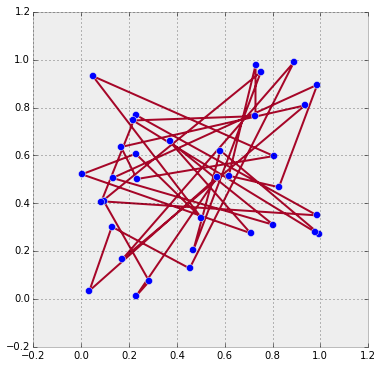

In [51]:
# Create a list of 35 points. The ``tour'' is given
# by the order in which they appear in the array.
# Visualise the tour and print the length.
N =  35
cities = np.random.random((2, N))
draw(cities)
print('Length of tour is: ', length(cities))

In [52]:
# Use simulated annealing to find a hopefully better solution

alpha = 0.8
Niter = 100
T     = 10
Tmin  = 1e-6
lens  = []
Ts    = []
while T > Tmin:
    for i in range(Niter):
        # Create random modification and calculate length of both
        new = neighbour(cities)
        old_cost = length(cities)
        new_cost = length(new)
        # Create lists for plotting
        lens.append(length(cities))
        Ts.append(T)
        # Acceptance probability
        ap = np.exp((old_cost - new_cost)/T)
        if ap > random.random():
            cities = new
    # Decrease temperature
    T = T*alpha
        

Length of tour is:  5.36734664552


/Users/nordam/.virtualenvs/default/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


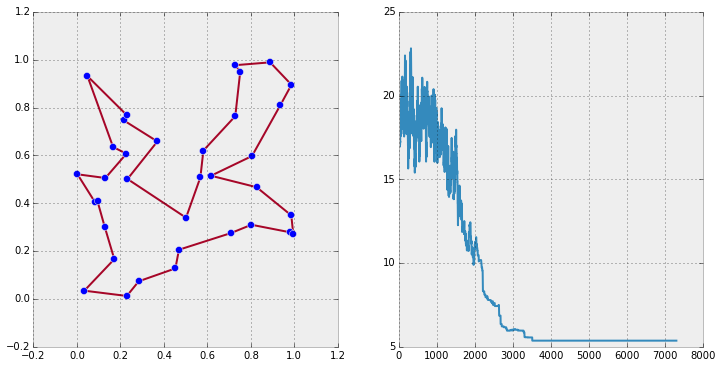

In [55]:
# Plot the tour that was found, and plot the development
# of the length as a function of iterations. Note how the
# length fluctuates in the beginning, and then tends to
# go more and more downwards as temperature decreases.
fig, ax = plt.subplots(ncols = 2, figsize = (12, 6))
draw(cities, ax = ax[0])
ax[1].plot(lens)
print('Length of tour is: ', length(cities))

## Downhill Simplex

In [146]:
# An object oriented implementation seemed like the natural choice here

# For a d-dimensional problem a Simplex consists of
# a list of d+1 Points.
# The Simplex has methods that transform it in accordance with
# the rules outlined in the algorithm.

class Point():
    pass

    # x is a d-vector of coordinates
    # f is the function to minimize
    def __init__(self, x, f):
        self.x = x
        self.f = f
        
    # Using the *-syntax we can evaluate the
    # function without knowing beforehand how many
    # arguments it expects.
    def evaluate(self):
        return self.f(*self.x)
    
    # By implementing the __lt__ method, we can compare
    # objects directly, and also sort them using built-in
    # python functions.
    def __lt__(self, other):
        return self.evaluate() < other.evaluate()

class Simplex():
    # expansion factor
    alpha = 2
    # contraction factor
    rho   = 0.5
    # shrink factor
    sigma = 0.8
    
    def __init__(self, N, f, scale = 1):
        # N+1 points in N dimensions
        self.dimensions = N
        self.points = []
        # Add a random first point
        x = scale*(2*np.random.random(size = N) - 1)
        self.points.append(Point(x, f))
        # Then add N more points,
        # each with an offset along one dimension
        Id = np.identity(N)
        for i in range(N):
            # Add offset by using rows from identity matrix
            self.points.append(Point(x + scale*Id[i,:], f))
        self.sort()
            
    def first(self):
        return self.points[0]
        
    def second(self):
        return self.points[1]
        
    def best(self):
        return self.points[-1]
        
    def sort(self):
        # sort, then reverse, to get largest first
        self.points = sorted(self.points)[::-1]
        
    def reflect(self):
        # Assumes that points are sorted, with largest first
        # Find center (average) of the N other points
        center = np.zeros(self.dimensions)
        for i in range(1, self.dimensions+1):
            center += self.points[i].x
        center = center / self.dimensions
        # Reflect the first point through the center
        x = self.points[0].x
        self.points[0].x = x + 2*(center - x)
        
    def expand(self):
        # Assumes that reflection has just been carried out,
        # so that the first point is the one that was moved
        # Find center (average) of the N other points
        center = np.zeros(self.dimensions)
        for i in range(1, self.dimensions+1):
            center += self.points[i].x
        center = center / self.dimensions
        # Move the first point away from the center
        x = self.points[0].x
        self.points[0].x = x + self.alpha * (x - center)
        
    def contract(self):
        # Assumes that reflection has just been carried out,
        # so that the first point is the one that was moved
        # Find center (average) of the N other points
        center = np.zeros(self.dimensions)
        for i in range(1, self.dimensions+1):
            center += self.points[i].x
        center = center / self.dimensions
        # Move the first point closer to the center
        x = self.points[0].x
        self.points[0].x = x - self.rho * (x - center)
        
    def shrink(self):
        # Move all points closer to the best one
        self.sort()
        # The best point is now the last
        x0 = self.points[self.dimensions].x
        for i in range(self.dimensions):
            x = self.points[i].x
            self.points[i].x = x - self.sigma * (x - x0)

    # Convenience function to visualise a 2D simplex
    def draw(self):
        if self.dimensions == 2:
            Np = 50
            xmin, xmax = -10, 10
            ymin, ymax = -10, 10
            x, y = np.meshgrid(np.linspace(xmin, xmax, Np), np.linspace(ymin, ymax, Np))
            fig = plt.figure(figsize = (8,8))
            ax  = fig.add_subplot(111, aspect = 'equal')
            ax.set_xlim(xmin, xmax)
            ax.set_ylim(ymin, ymax)
            mesh = ax.pcolormesh(x, y, f(x, y), cmap = plt.get_cmap('winter'), zorder = 0)
            plt.colorbar(mesh)
            for i in range(self.dimensions+1):
                x1, y1  = self.points[i-1].x
                x2, y2  = self.points[i].x
                ax.plot([x1, x2], [y1, y2], zorder = 1, color = '#A60628', lw = 1 )
                ax.scatter(x1, y1, zorder = 2, color = '#A60628')

    # This function carries out one iteration.
    # Call repeatedly to find minimum.
    def iterate(self):
        self.sort()
        self.reflect()
        reflected = self.first()
        # If the new point is better than all others,
        # expand further in that direction
        if self.first() < self.best():
            self.expand()
            # if the expanded point is better than reflected point,
            # keep it and return
            if self.first() < reflected:
                return
            # Otherwise use the reflected point
            else:
                self.points[0] = reflected
                return
        # If the new point is not best, but better than
        # the second worst, keep it and return
        elif self.first() < self.second():
            return
        # Otherwise, the reflected point is the worst
        else:
            self.contract()
            if self.first() < reflected:
                # If the contracted point was an improvement,
                # keep it
                return
            else:
                self.points[0] = reflected
                self.shrink()
                return

In [136]:
# Define a function in two dimensions
def f(x, y):
    return x**2 + y**2

# Create a simplex
s = Simplex(2, f, scale = 2)

Reflecting


0.76037637261656477

/Users/nordam/.virtualenvs/default/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


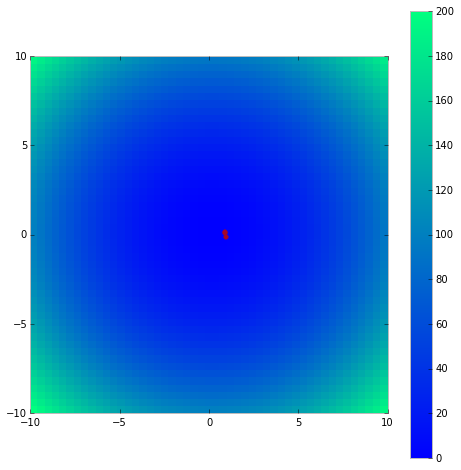

In [145]:
# Execute this cell repeatedly with ctrl + enter
# to see how the simplex changes
s.iterate()
s.draw()
s.best().evaluate()

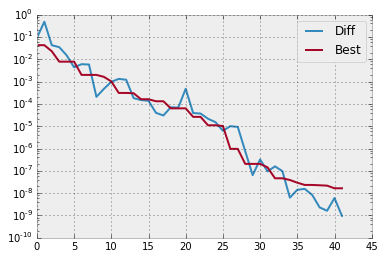

In [174]:
# Create a simplex
s = Simplex(2, f, scale = 2)
# Sort points to get worst point first in list
s.sort()
# Iterate until difference between worst and best is small
diff = s.first().evaluate() - s.best().evaluate()
tol = 1e-9
# Create lists for visualisation purposes
diffs = []
bests = []
while diff > tol:
    s.iterate()
    s.sort()
    diff = s.first().evaluate() - s.best().evaluate()
    # Create lists for visualisation purposes
    diffs.append(diff)
    bests.append(s.best().evaluate())

plt.plot(diffs, label = 'Diff')
plt.plot(bests, label = 'Best')
plt.yscale('log')
plt.legend()

## Genetic algorithms

An example of using Genetic Algorithms to find approximate solutions to the Travelling Salesman Problem.

See for example https://en.wikipedia.org/wiki/Genetic_algorithm for more information.

In [228]:
# Again, this type of approach lends itself well to an object oriented implementation.

# A class to hold a list of cities (x and y positions)
class Cities():
    pass

    def __init__(self, N):
        self.N = N
        self.X = np.random.random((2, N))
    
    def draw(self):
        xmin, xmax = -0.2, 1.2
        ymin, ymax = -0.2, 1.2
        fig = plt.figure(figsize = (6,6))
        ax  = fig.add_subplot(111, aspect = 'equal')
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        for i in range(self.N):
            ax.scatter(self.X[0, i], self.X[1, i], zorder = 2, color = '#A60628')

# A class to hold one realisation of a tour of all cities
# It stores the positions of the cities, and in a separate
# list the order in which the are to be visited.
class Tour():
    pass

    def __init__(self, cities, order = None):
        self.cities = cities
        self.N      = cities.X.shape[1]
        self.length = None
        if order is None:
            self.order = np.arange(self.N)
            np.random.shuffle(self.order)
        else:
            self.order = order
    
    # Implement __lt__ to be able to compare two tours
    # and to sort a list of tours.
    def __lt__(self, other):
        return self.dist() < other.dist()
    
    # Function to return the length of the tour
    # We typically need to evaluate each tour several times
    # for each generation, so we save time by storing the result
    # instead of computing it every time.
    def dist(self):
        # If the length is not stored, calculate it
        if self.length is None:
            dist = 0
            for i in range(self.N):
                X1 = self.cities.X[:,self.order[i-1]]
                X2 = self.cities.X[:,self.order[i]]
                dist += np.sqrt(np.sum((X2 - X1)**2))
            # Store the length
            self.length = dist
        # Return the length
        return self.length

    # Convenience function to visualise a tour
    def draw(self):
        xmin, xmax = -0.2, 1.2
        ymin, ymax = -0.2, 1.2
        fig = plt.figure(figsize = (6,6))
        ax  = fig.add_subplot(111, aspect = 'equal')
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        for i in range(self.N):
            X1 = self.cities.X[:,self.order[i-1]]
            X2 = self.cities.X[:,self.order[i]]
            ax.plot([X1[0], X2[0]], [X1[1], X2[1]], zorder = 1, color = '#348ABD', lw = 1 )
            ax.scatter(X1[0], X1[1], zorder = 2, color = '#A60628')
            
    # Randomly switch two cities
    def mutate(self):
        # switch two random cities
        # (randint is inclusive in the upper limit)
        a, b = np.random.randint(0, self.N-1, size = 2)
        self.order[a], self.order[b] = self.order[b], self.order[a]
        # This changes the length of the tour,
        # so we delete the stored length.
        self.length = None
        
    def crossover(self, other):
        # Create one offspring by selecting a random
        # sequence from self, then insert the missing cities
        # in the order they appear in the other
        order = -1*np.ones(self.N, dtype = np.int32)
        a, b = np.random.randint(0, self.N-1, size = 2)
        if a > b:
            a, b = b, a
        order[a:b] = self.order[a:b]
        j = 0
        for i in range(a):
            while other.order[j] in order:
                j += 1
            order[i] = other.order[j]
        for i in range(b, self.N):
            while other.order[j] in order:
                j += 1
            order[i] = other.order[j]
        return Tour(self.cities, order = order)
    
# Class to store a collection of tours, and provide
# methods to do selection and evolution
class Population():
    mutationrate   = 0.02
    tournamentsize = 7
    elitism        = 1

    def __init__(self, cities, Ntours):
        self.cities = cities
        self.Ntours = Ntours
        self.tours  = np.zeros(Ntours, dtype = object)
        for i in range(self.Ntours):
            self.tours[i] = Tour(cities)
            
    # Function used to select "individuals" to create the next
    # generation. There are many variants of selection, but
    # tournament is common and easy to implement.
    def tournament(self):
        # Select N random tours, and return the best of those
        mask = np.zeros(self.Ntours, dtype = np.bool)
        mask[:self.tournamentsize] = True
        np.random.shuffle(mask)
        return sorted(self.tours[mask])[0]
    
    # Takes the entire population one generation forwards.
    def evolve(self):
        # Array to hold the next generation
        new_tours = np.zeros(self.Ntours, dtype = object)
        # If elitism is active, the best e individuals are
        # copied directly into the next generation.
        e = self.elitism
        new_tours[:e] = sorted(self.tours)[:e]
        # Make up the reminder by combining two from the
        # previous generation into one new individual.
        for i in range(e, self.Ntours):
            tour1 = self.tournament()
            tour2 = self.tournament()
            new_tours[i] = tour1.crossover(tour2)
            # Randomly apply some mutation here and there
            if np.random.random() < self.mutationrate:
                new_tours[i].mutate()
        self.tours = new_tours
        
    def best(self):
        return sorted(self.tours)[0]
    
    def worst(self):
        return sorted(self.tours)[-1]

In [229]:
cities = Cities(30)
pop    = Population(cities, 500)

10.484418901234287

/Users/nordam/.virtualenvs/default/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


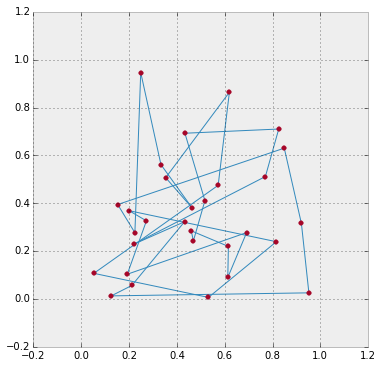

In [230]:
# Draw the currently best solution, and print its length
pop.best().draw()
pop.best().dist()

In [231]:
# Total numb
# Number of iterations (``generations'')
Niter = 50
# 
bests = []
worsts = []
for i in range(Niter):
    print('Generation %s of %s' % (i, Niter), '\r', end = '')
    pop.evolve()
    bests.append(pop.best().dist())
    worsts.append(pop.worst().dist())

5.0273267535345019

/Users/nordam/.virtualenvs/default/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


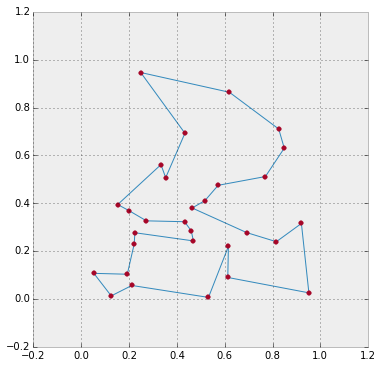

In [233]:
# Draw the currently best solution, and print its length
pop.best().draw()
pop.best().dist()

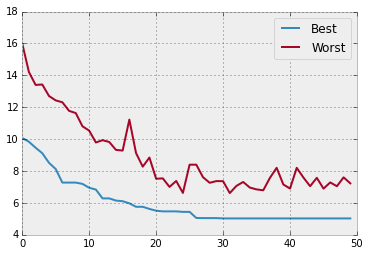

In [234]:
# Plot the evalution of the best and worst members
# of the population. If elitims > 0, the length of
# the best should never increase.
plt.plot(bests, label = 'Best')
plt.plot(worsts, label = 'Worst')
plt.legend()